## Convolutional Neural Networks (CNN) for FashionMNIST

FashionMNIST is a dataset of 60,000 training images and 10,000 test images, each of size 28x28 grayscale, categorized into 10 different fashion classes (e.g., T-shirt, dress, sneaker, etc.). 

### Part 1: Data Preprocessing

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [19]:
# Load the FashionMNIST dataset and normalize the images to the range [0,1] 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

In [20]:
# Split the dataset into training and validation sets
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

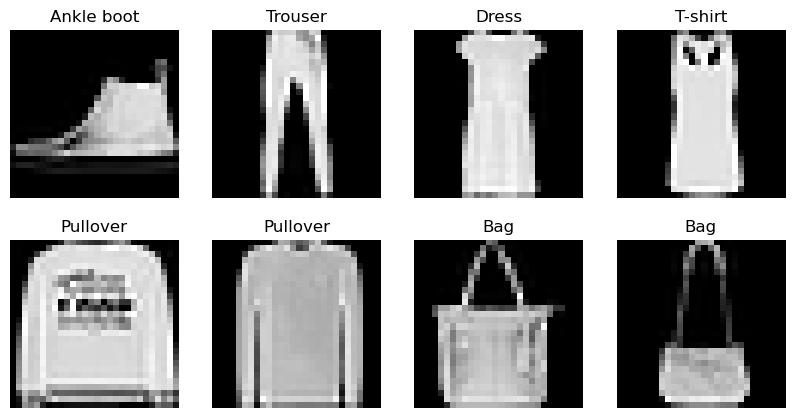

In [21]:
# Display some images
images, labels = next(iter(train_loader))
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

### Part 2: Building the CNN Model

In [23]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model and optimizer
model = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Part 3: Training & Evaluation

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        # Record metrics
        train_loss = running_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=15
)

Epoch 1/15 | Train Loss: 0.5216 | Val Loss: 0.3441
Epoch 2/15 | Train Loss: 0.3389 | Val Loss: 0.3145
Epoch 3/15 | Train Loss: 0.2861 | Val Loss: 0.2614
Epoch 4/15 | Train Loss: 0.2514 | Val Loss: 0.2465
Epoch 5/15 | Train Loss: 0.2258 | Val Loss: 0.2540
Epoch 6/15 | Train Loss: 0.2065 | Val Loss: 0.2355
Epoch 7/15 | Train Loss: 0.1858 | Val Loss: 0.2325
Epoch 8/15 | Train Loss: 0.1696 | Val Loss: 0.2344
Epoch 9/15 | Train Loss: 0.1537 | Val Loss: 0.2345
Epoch 10/15 | Train Loss: 0.1409 | Val Loss: 0.2452
Epoch 11/15 | Train Loss: 0.1265 | Val Loss: 0.2487
Epoch 12/15 | Train Loss: 0.1171 | Val Loss: 0.2476
Epoch 13/15 | Train Loss: 0.1056 | Val Loss: 0.2702
Epoch 14/15 | Train Loss: 0.0993 | Val Loss: 0.2551
Epoch 15/15 | Train Loss: 0.0917 | Val Loss: 0.2781


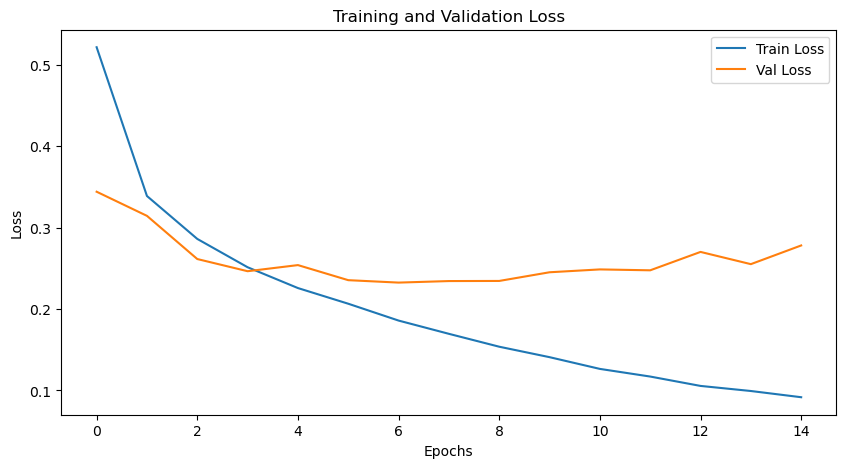

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [26]:
def evaluate_accuracy(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

test_acc = evaluate_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 91.63%


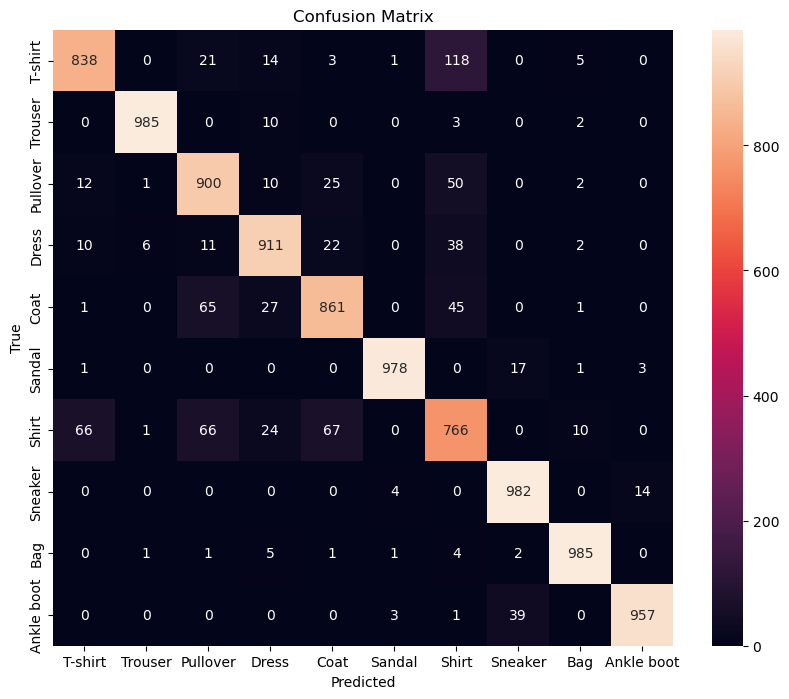

In [27]:
def plot_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_loader)

### Part 4: Experimentation & Improvements 

In [28]:
class ImprovedFashionCNN(nn.Module):
    def __init__(self):
        super(ImprovedFashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # Note: 3x3 after 3 pooling layers
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Train and compare
improved_model = ImprovedFashionCNN().to(device)
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)
improved_losses, _ = train_model(improved_model, train_loader, val_loader, criterion, optimizer, epochs=15)
improved_acc = evaluate_accuracy(improved_model, test_loader)
print(f"Improved Model Test Accuracy: {improved_acc * 100:.2f}%")

Epoch 1/15 | Train Loss: 0.4151 | Val Loss: 0.3020
Epoch 2/15 | Train Loss: 0.2733 | Val Loss: 0.2752
Epoch 3/15 | Train Loss: 0.2254 | Val Loss: 0.2307
Epoch 4/15 | Train Loss: 0.1996 | Val Loss: 0.2161
Epoch 5/15 | Train Loss: 0.1737 | Val Loss: 0.2088
Epoch 6/15 | Train Loss: 0.1512 | Val Loss: 0.2260
Epoch 7/15 | Train Loss: 0.1343 | Val Loss: 0.2384
Epoch 8/15 | Train Loss: 0.1162 | Val Loss: 0.2433
Epoch 9/15 | Train Loss: 0.1021 | Val Loss: 0.2383
Epoch 10/15 | Train Loss: 0.0887 | Val Loss: 0.2290
Epoch 11/15 | Train Loss: 0.0805 | Val Loss: 0.2730
Epoch 12/15 | Train Loss: 0.0687 | Val Loss: 0.2820
Epoch 13/15 | Train Loss: 0.0671 | Val Loss: 0.2887
Epoch 14/15 | Train Loss: 0.0561 | Val Loss: 0.3282
Epoch 15/15 | Train Loss: 0.0520 | Val Loss: 0.3234
Improved Model Test Accuracy: 91.71%


In [29]:
# Augmented transforms
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Reload datasets with augmentation
aug_train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=aug_transform
)
aug_train_dataset, _ = random_split(aug_train_dataset, [train_size, val_size])
aug_train_loader = DataLoader(aug_train_dataset, batch_size=batch_size, shuffle=True)

# Train with augmented data
aug_model = FashionCNN().to(device)
optimizer = optim.Adam(aug_model.parameters(), lr=0.001)
aug_losses, _ = train_model(aug_model, aug_train_loader, val_loader, criterion, optimizer, epochs=15)
aug_acc = evaluate_accuracy(aug_model, test_loader)
print(f"Augmented Data Test Accuracy: {aug_acc * 100:.2f}%")

Epoch 1/15 | Train Loss: 0.5788 | Val Loss: 0.3564
Epoch 2/15 | Train Loss: 0.3938 | Val Loss: 0.3168
Epoch 3/15 | Train Loss: 0.3423 | Val Loss: 0.2892
Epoch 4/15 | Train Loss: 0.3170 | Val Loss: 0.2592
Epoch 5/15 | Train Loss: 0.2946 | Val Loss: 0.2424
Epoch 6/15 | Train Loss: 0.2818 | Val Loss: 0.2229
Epoch 7/15 | Train Loss: 0.2656 | Val Loss: 0.2112
Epoch 8/15 | Train Loss: 0.2556 | Val Loss: 0.2165
Epoch 9/15 | Train Loss: 0.2491 | Val Loss: 0.1911
Epoch 10/15 | Train Loss: 0.2376 | Val Loss: 0.1798
Epoch 11/15 | Train Loss: 0.2308 | Val Loss: 0.1803
Epoch 12/15 | Train Loss: 0.2273 | Val Loss: 0.1820
Epoch 13/15 | Train Loss: 0.2174 | Val Loss: 0.1656
Epoch 14/15 | Train Loss: 0.2114 | Val Loss: 0.1593
Epoch 15/15 | Train Loss: 0.2096 | Val Loss: 0.1637
Augmented Data Test Accuracy: 91.45%


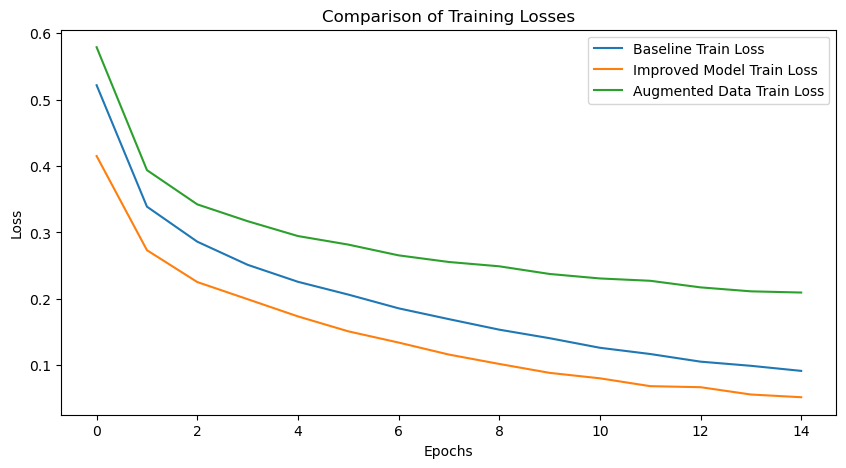

Baseline Accuracy: 91.63%
Improved Model Accuracy: 91.71%
Augmented Data Accuracy: 91.45%


In [30]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Baseline Train Loss')
plt.plot(improved_losses, label='Improved Model Train Loss')
plt.plot(aug_losses, label='Augmented Data Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparison of Training Losses')
plt.show()

print(f"Baseline Accuracy: {test_acc * 100:.2f}%")
print(f"Improved Model Accuracy: {improved_acc * 100:.2f}%")
print(f"Augmented Data Accuracy: {aug_acc * 100:.2f}%")